Прообраз: https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb

In [173]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [174]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [175]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print("Количество слов в словаре:", dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)


# Фильтрация

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

# Убираются слова, которые попадаются всего в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

Количество слов в словаре: 75725
75180
19310
1819


In [176]:
# Установка количества тем
topic_count = 20

# Создание модели
model_artm = artm.ARTM(
    topic_names=['topic_{}'.format(i) for i in range(topic_count)],
    #regularizers=[
    #    artm.SmoothSparseThetaRegularizer(
    #        name='SparseTheta', 
    #        tau=-0.15
    #    )
    #],
    cache_theta=True,
    #class_ids={'text': 1.0},
)

# Инициализация модели
model_artm.initialize(dictionary=dictionary)
model_artm.num_document_passes = 1

In [177]:
# Установка отслеживаемых параметров
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.save("news_model_0")

In [178]:
def model_print_results(model_artm):
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(221)   #top left
    ax1.plot(model_artm.score_tracker["SparsityPhiScore"].value)
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('SparsityPhiScore')
    ax1.grid(True)

    ax2 = fig.add_subplot(222)   #top right
    ax2.plot(model_artm.score_tracker["SparsityThetaScore"].value)
    ax2.set_xlabel('Iterations count')
    ax2.set_ylabel('SparsityThetaScore')
    ax2.grid(True)

    ax3 = fig.add_subplot(223)   #bottom left
    ax3.plot(model_artm.score_tracker["PerplexityScore"].value)
    ax3.set_xlabel('Iterations count')
    ax3.set_ylabel('PerplexityScore')
    ax3.grid(True)

    plt.show()
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)

Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

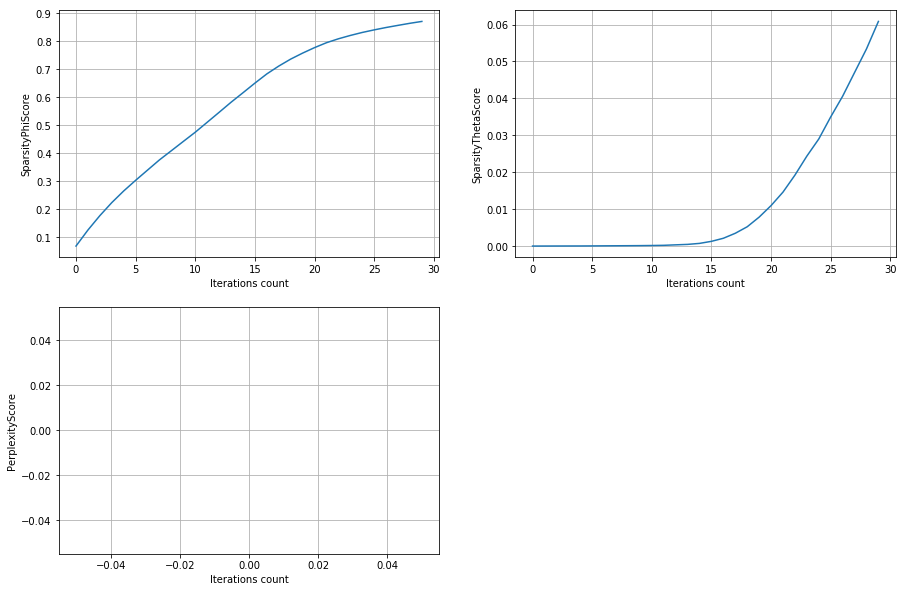

SparsityPhiScore: 0.87020343542099
SparsityThetaScore: 0.06083836033940315


In [179]:
# Модель 1
# Запуск регуляризатора SparsePhi

model_artm.load("news_model_0")

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi'), overwrite=True)
model_artm.regularizers['SparsePhi'].tau = -4

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
model_print_results(model_artm)

model_artm.save("news_model_1")

In [ ]:
model_artm.regularizers

[SparsePhi]

In [ ]:
# Модель 1
# Запуск регуляризатора SparseTheta

model_artm.load("news_model_1")

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta'), overwrite=True)
model_artm.regularizers['SparseTheta'].tau = -7

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
model_print_results(model_artm)

model_artm.save("news_model_2")

In [ ]:
model_artm.regularizers

In [131]:
# Установка регуляризаторов
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi'))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi'))


#model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=0.1))

In [132]:
# Правка регуляризаторов
model_artm.regularizers['SparsePhi'].tau = -3
#model_artm.regularizers['SparseTheta'].tau = -2
#model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [136]:
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
model_artm.regularizers['SparseTheta'].tau = -2

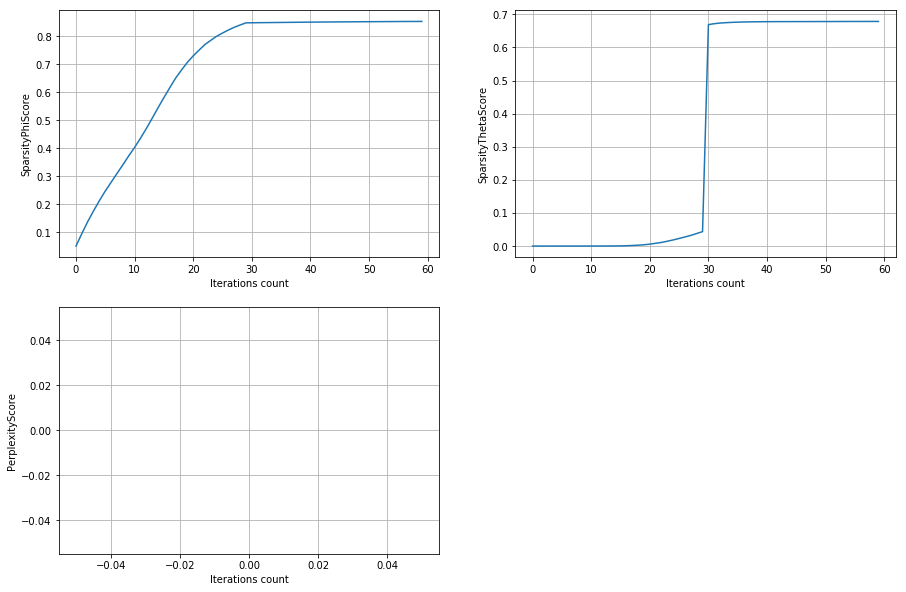

SparsityPhiScore: 0.85197913646698
SparsityThetaScore: 0.6784400939941406


In [137]:
# Первичное обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
model_results(model_artm)

In [153]:
#topic_list = model_artm.topic_names
topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())

for topic_name in topic_list:
    print(topic_name + ': ', end='')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['передача', 'специалист', 'использовать', 'исследование', 'высокий', 'специальный', 'цена', 'технический', 'поставлять', 'подобный']
topic_1: ['партия', 'публичный', 'инфо', 'оппозиционер', 'вконтакте', 'оштрафовать', 'борьба', 'сторонник', 'экстремизм', 'твиттер']
topic_2: ['обвинительный', 'преступный', 'причастность', 'отсутствие', 'эпизод', 'тяжкий', 'соглашаться', 'вскоре', 'несмотря', 'освобождать']
topic_3: ['предприятие', 'бизнесмен', 'мошенничество', 'министр', 'миллион', 'чиновник', 'имущество', 'рабочий', 'банк', 'зарплата']
topic_4: ['родитель', 'устройство', 'вещество', 'магазин', 'звонок', 'предмет', 'заставлять', 'торговый', 'студент', 'возле']
topic_5: ['служебный', 'подросток', 'несовершеннолетний', 'проводиться', 'гибель', 'пожар', 'детский', 'мальчик', 'четверо', 'обязанность']
topic_6: ['участок', 'выборы', 'здесь', 'подпись', 'напоминать', 'читать', 'оглашать', '2009', 'перерыв', 'общаться']
topic_7: ['взрыв', 'паспорт', 'вещь', 'зачитывать', 'полагать', 

In [25]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-5*1e5, dictionary=dictionary),
    overwrite=True,
)

In [30]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

In [31]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['использовать', 'нужно', 'создавать', 'третий', 'почти', 'отсутствие']
topic_1: 
['партия', 'призыв', 'социальный', 'публичный', 'телеканал', 'политика']
topic_2: 
['николай', 'юрий', 'сообщество', 'потребовать', 'изолятор', 'прекращать']
topic_3: 
['особо', 'предприятие', 'бизнесмен', 'мошенничество', 'занимать', 'должность']
topic_4: 
['сидеть', 'отец', 'вспоминать', 'дверь', 'бить', 'правый']
topic_5: 
['служебный', 'ударять', 'превышение', 'повреждение', 'подросток', 'умирать']
topic_6: 
['помнить', 'поддерживать', 'минута', 'коллега', 'событие', 'снова']
topic_7: 
['покушение', 'известный', 'официальный', 'подозревать', 'офис', 'борис']
topic_8: 
['возможность', 'иностранный', 'госдума', 'подписывать', 'министерство', 'список']
topic_9: 
['удаваться', 'пистолет', 'угрожать', 'накануне', 'открывать', 'проводиться']


In [32]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8992853164672852
0.20184320211410522


Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664

In [38]:
model_artm.score_tracker

{'PerplexityScore': <artm.score_tracker.PerplexityScoreTracker at 0x104a838d0>,
 'SparsityPhiScore': <artm.score_tracker.SparsityPhiScoreTracker at 0x10ed47c88>,
 'SparsityThetaScore': <artm.score_tracker.SparsityThetaScoreTracker at 0x10ed47cf8>,
 'TopTokensScore': <artm.score_tracker.TopTokensScoreTracker at 0x1119dcbe0>,
 'TopicKernelScore': <artm.score_tracker.TopicKernelScoreTracker at 0x10ed47d30>}